# MNIST For ML Beginners: The Bayesian Way
**(c) 2017 Sreekumar Thaithara Balan, Fergus Simpson and Richard Mason, Alpha-I**. 

Download this notebook at: [link]

In [41]:
from IPython.display import Image

## Introduction

This tutorial is intended for readers who are new to machine learning, TensorFlow and Bayesian Methods. Our intention is to teach you how to train your first Bayesian neural network, and provide a Bayesian companion to the well known [getting started example](https://www.tensorflow.org/get_started/mnist/beginners) in TensorFlow.

So why do we need Bayesian neural networks? Traditionally neural networks are trained to produce a point estimate of some variable of interest. For example, we might train a neural network to produce a prediction of a stock price at a future point in time using historical data. The limitation of a single point estimate is that it does not provide us with any measure of the uncertainty in this prediction. If the network predicts that the stock will increase in value with 95% confidence then we probably have an easy decision to buy, but what if the network has only a 50% confidence? With point estimates we just don't know how uncertain we are. By contrast, Bayesian neural networks enable us to estimate the uncertainty in our predictions using Bayes' rule. 


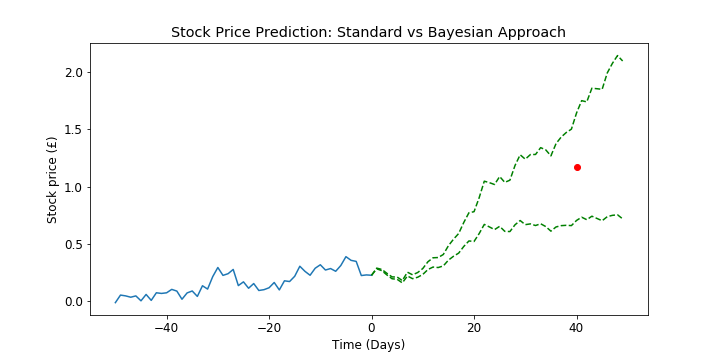

In [42]:
Image("stock_price.png")

Figure shows a point estimate (red circle) of a stock price 40 days in the future along with 95% confidence bounds (green dotted lines). Without a measure of the uncertainty we cannot understand how much risk we are taking when we trade.

## About this tutorial

In this tutorial, we will learn about:

+ How Bayesian statistics are related to machine learning.
+ How to construct a Bayesian model for the classification of MNIST images.
+ How Bayesian neural networks can quantify uncertainties in predictions.

For more background information on Bayesian Neural Networks, Thomas Wiecki's blog on [Bayesian Deep Learning](http://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/) and Yarin Gal's blog [What my deep model doesn't know...](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html) are extremely useful starting points.

The tutorial requires [TensorFlow](https://www.tensorflow.org/) *version 1.1.0* and [Edward](http://edwardlib.org/) *version 1.3.1*.

## Bayesian Neural Networks

So what is a Bayesian Neural Network? To understand their nature, we'll begin with a brief outline of Bayesian statistics. At its core, Bayesian statistics is about how we should alter our beliefs in light of new information.

### Bayes' rule: 

Suppose that we have two events $x, y$ and we want to know the conditional probability distribution of $x$ given $y$, which is written as $P(x \;|\;y)$. Bayes' rule tells us that

$$ P(x \;|\;y) = \frac{P(y\;|\;x)P(x)}{P(y)}$$

where $P(y\;|\;x)$ is the likelihood of observing event $y$ given $x$, $P(x)$ is our prior belief about $x$, and $P(y)$ is the probability of event $y$. Note that our prior belief about the variable $x$ is a probability distribution and that we obtain an entire distribution on the possible values of $x$ given $y$ as opposed to a single point estimate.

### Neural Networks

So how does Bayes' rule connect to neural networks? In this section we'll explain how 'conventional' neural networks already make use of Bayes' rule under certain assumptions on the regularisation term used during training. 

Suppose that we are given a data set $D= \{(x_{i},y_{i})\}_{i=1}^{N}$ consisting of pairs of inputs $x_{i}$ and corresponding outputs $y_{i}$ for $i=1,2,\ldots,N$. We can use a neural network to model the likelihood function $P(y\;|\;x;\omega)$, where $\omega$ is the set of tunable parameters of the model i.e., the weights and biases of the network. For example, for a classification problem we could use a standard feedforward network, $y_{i} = f(x_{i};\omega)$ followed by a softmax layer to normalise output so that it represents a valid probability mass function $P(y_{i}\;|\;x_{i};\omega)$.

Traditional approaches to training neural networks typically produce a point estimate by optimising the weights and biases to minimize a loss function, such as a cross-entropy loss in the case of a classification problem. From the probabilistic viewpoint, this is equivalent to maximising the log likelihood of the observed data $P(D\;|\;\omega)$ to find the maximum likelihood estimate (MLE) [Blundell et. al. 2015](https://arxiv.org/abs/1505.05424)

$$ \omega^{\text{MLE}} = \text{arg}\underset{\omega}{\text{max}} \;\log{P(D\;|\;\omega)}$$
$$ \quad\quad\quad\quad = \text{arg}\underset{\omega}{\text{max}} \;\sum_{i=1}^{N}\log{P(y_{i}\;|\;x_{i},\omega)}$$


This optimisation is typically carried out using some form of gradient descent (e.g., backpropagation), and then with the weights and biases fixed we can predict a new output $y^{*}=f(x^{*};\omega)$ for a given input $x^{*}$.

Training a neural network in this way is well known to be prone to overfitting and so often we introduce regularisation term such as an $L_{2}$ norm of the weights. One  can show that placing $L_{2}$ regularization of the weights is equivalent to placing a normal Gaussian prior $P(\omega)\sim\mathcal(0,I)$ on the weights and maximising the a-priori estimate $p(\omega\;|\;D)$. This gives us the Maximum a-Priori estimate (MAP) of the parameters (see chapter 41 of MacKay's [book](http://www.inference.phy.cam.ac.uk/itprnn/book.html) for details):

$$ \omega^{\text{MAP}} = \text{arg}\underset{\omega}{\text{max}}\;\log{P(\omega\;|\;D)}$$
$$ \quad\quad\quad\quad\quad\quad\;\; = \text{arg}\underset{\omega}{\text{max}}\;\log{P(D\;|\;\omega)} + \log{P(\omega)}.$$

From this we can see that traditional approaches to neural network training and regularisation can be placed within the framework of performing inference using Bayes' rule. Bayesian Neural Networks go one step further by trying to approximate the entire posterior distribution $P(\omega \;|\; D)$ using either Monte Carlo or Variational Inference techniques. In the rest of the tutorial we will show you how to do this using Tensorflow and [Edward](http://edwardlib.org/).

## Importing data
Let us import the [MNIST images](http://yann.lecun.com/exdb/mnist/) using the built in TensorFlow methods.

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from edward.models import Categorical, Normal
import edward as ed
import pandas as pd

In [44]:
# Use the TensorFlow method to download and/or load the data.
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True) 

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Modeling

Recall that our task is to classify the handwritten MNIST digits into one of the classes {0,1,2,...,9} and give a measure of the uncertainty of our classification. Our machine learning model will be a simple soft-max regression, and for this we first need to choose a likelihood function to quantify the probability of the observed data given a set of parameters (weights and biases in our case). We will use a Categorical likelihood function (see Chapter 2, [Machine Learning: a Probabilistic Perspective](https://www.cs.ubc.ca/~murphyk/MLbook/) by Kevin Murphy for a detailed description of Categorical distribution, also called Multinoulli distribution.).

We next set up some placeholder variables in TensorFlow. This follows the same procedure as you would for a standard neural network except that we use Edward to place priors on the weights and biases. In the code below, we place a normal Gaussian prior on the weights and biases.

In [45]:
ed.set_seed(31415)
N = 100   # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.

RuntimeError: Seeding is not supported after initializing part of the graph. Please move set_seed to the beginning of your code.

In [46]:
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w = Normal(loc=tf.zeros([D, K]), scale=tf.ones([D, K]))
b = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y = Categorical(tf.matmul(x,w)+b)

## Variational Inference

Up to this point we have defined the likelihood $P(y\;|\;x,;\omega)$ and the prior $P(\omega)$, next we want to use Bayes rule to compute the posterior $P(\omega\;|\;y,x)$. However, we immediately face a problem because in practice the probability of the outputs $P(y)$ is computationally intractable to compute for large instances and so we don't attempt to calculate the posterior directly.

To tackle this problem we will instead be using Variational Inference (VI). In Variational Inference we choose a family of parameterised distributions $Q(\omega;λ)$ over parameters $\omega$ to approximate the true posterior, and then optimize the parameters $\lambda$ so as to match the true posterior distribution as best as possible. The core idea is to minimise what is known as the Kullback-Leibler divergence between the true posterior $P(\omega\;|\;y,x)$ and the approximating ditribution $Q(\omega;λ)$, which can be thought of as a measure of the disimilarity between two probability distributions.

The theory behind VI is beyond the scope of this blog, so more more information a quick introduction to VI can be found in Edward's documentation and a detailed one in Variational Inference: A Review for Statisticians by Blei et al.. Chapter 33 or MacKay's book is also a very good reference.

So next we use Edward to set up the approximating distributions $Q_{w}(\omega)$ for the weights and $Q_{b}(\omega)$ for the biases:

In [47]:
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw = Normal(loc=tf.Variable(tf.random_normal([D, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, K])))) 
qb = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))

In [48]:
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = ed.KLqp({w: qw, b: qb}, data={y:y_ph})

In [49]:
# Initialse the infernce variables
inference.initialize(n_iter=5000, n_print=100, scale={y: float(mnist.train.num_examples) / N})

Now we are ready to perform Variational Inference. We load up a TensorFlow session and start the iterations. This may take a few minutes...

In [50]:
# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()

ValueError: GraphDef cannot be larger than 2GB.

In [ ]:
# Let the training begin. We load the data in minibatches and update the VI infernce using each new batch.
for _ in range(inference.n_iter):
    X_batch, Y_batch = mnist.train.next_batch(N)
    # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
    Y_batch = np.argmax(Y_batch,axis=1)
    info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
    inference.print_progress(info_dict)

## Evaluating Our Model
We now have everything that we need to run our model on the test data, let's see how good our model is! The major difference in Bayesian model evaluation is that there is no single value for the weights and biases that we should use to evaluate the model. Instead we should use the distribution of weights and biases in our model so that the uncertainties in these parameters are reflected in the final prediction. Thus instead of a single prediction we get a set of predictions and their accuracies.

We draw a 100 samples from the posterior distribution and see how we perform on each of these samples. *Taking samples be might a slow process, may take few seconds!*

In [ ]:
# Load the test images.
X_test = mnist.test.images
# TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
Y_test = np.argmax(mnist.test.labels,axis=1)

In [ ]:
# Generate samples the posterior and store them.
n_samples = 100
prob_lst = []
samples = []
w_samples = []
b_samples = []
for _ in range(n_samples):
    w_samp = qw.sample()
    b_samp = qb.sample()
    w_samples.append(w_samp)
    b_samples.append(b_samp)
    # Also compue the probabiliy of each class for each (w,b) sample.
    prob = tf.nn.softmax(tf.matmul( X_test,w_samp ) + b_samp)
    prob_lst.append(prob.eval())
    sample = tf.concat([tf.reshape(w_samp,[-1]),b_samp],0)
    samples.append(sample.eval())

In [ ]:
# Compute the accuracy of the model. 
# For each sample we compute the predicted class and compare with the test labels.
# Predicted class is defined as the one which as maximum proability.
# We perform this test for each (w,b) in the posterior giving us a set of accuracies
# Finally we make a histogram of accuracies for the test data.
accy_test = []
for prob in prob_lst:
    y_trn_prd = np.argmax(prob,axis=1).astype(np.float32)
    acc = (y_trn_prd == Y_test).mean()*100
    accy_test.append(acc)

plt.hist(accy_test)
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")

We have a range of accuacies for the samples. Note that posterior distributions of weights and biases refect the information gained from the entire MNIST test data. Thus the above histogram is representative of the uncertainty coming from the statistically possible range of weights and biases.

We can perform a model averaging and try to get a equivalent of a classical machine learning model. We do this by stacking up the predictions of the 100 samples we took from the posterior distribution and then computing the average of the predictions.

In [ ]:
# Here we compute the mean of probabilties for each class for all the (w,b) samples.
# We then use the class with maximum of the mean proabilities as the prediction. 
# In other words, we have used (w,b) samples to construct a set of models and
# used their combined outputs to make the predcitions.
Y_pred = np.argmax(np.mean(prob_lst,axis=0),axis=1)
print("accuracy in predicting the test data = ", (Y_pred == Y_test).mean()*100)

We should also look at the posterior distribution. Unfortunately, the number of dimensions is quite large even for a small problem like this and so visualising them is tricky! We look at the first 5 dimensions and produce a triangle plot of the correlations.

In [ ]:
# Create a Pandas DataFrame of posterior samples.
samples_df = pd.DataFrame(data = samples, index=range(n_samples))
# Now create a small subset by taking the first 5 weights, labelled as W_0, ... , W_4.
samples_5 = pd.DataFrame(data = samples_df[list(range(5))].values,columns=["W_0", "W_1", "W_2", "W_3", "W_4"])
# We use Seaborn PairGrid to make a triale plot to show auto and cross correlations.
g = sns.PairGrid(samples_5, diag_sharey=False)
g.map_lower(sns.kdeplot, n_levels = 4,cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot,legend=False)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Joint posterior distribution of the first 5 weights')

We load up an image from the test data and see what classification we get for each sample from the posterior distribution of weights and biases.

In [ ]:
# Load the first image from the test data and its label.
test_image = X_test[0:1]
test_label = Y_test[0]
print('truth = ',test_label)
pixels = test_image.reshape((28, 28))
plt.imshow(pixels,cmap='Blues')

In [ ]:
# Now the check what the model perdicts for each (w,b) sample from the posterior. This may take a few seconds...
sing_img_probs = []
for w_samp,b_samp in zip(w_samples,b_samples):
    prob = tf.nn.softmax(tf.matmul( X_test[0:1],w_samp ) + b_samp)
    sing_img_probs.append(prob.eval())

In [ ]:
# Create a histogram of these predictions.
plt.hist(np.argmax(sing_img_probs,axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test digit")
plt.ylabel("Frequency")

As we can see, our model is very confident about the prediction here. For all the samples from the posterior, we predict the true value (this figure may be slightly different in different machines due to the ranom number generation).

## How does the model handle unfamiliar data?

What will the model tell us if we give it **completely different data** to that which we have used for training? This is a crucial test as we need to know not only a prediction but also the confidence with which we can claim that prediction. In many Artificial Intelligence applications this information extremely valuable. 

For this test we shall use the *notMNIST* data of alphabets and see how our model reacts to this data. Our hope is that if we pass it an unfamiliar image, say of a letter 'D', when it has previously only been trained on the digits {0,1,...,9}, then the model should output a classification but be highly uncertain about it.

We can download the notMNIST images from [here](http://yaroslavvb.com/upload/notMNIST/). The conversion to MNIST format is described [here](https://github.com/davidflanagan/notMNIST-to-MNIST). In this example we just use the converted data. We assume that all the required files are in the `notMNIST` folder and use the TensorFlow methods.

```bash
git clone git@github.com:davidflanagan/notMNIST-to-MNIST.git
mkdir notMNIST_data
cp notMNIST-to-MNIST/*.gz notMNIST_data
```

We assume that the `notMNIST_data` is in the same directory as this notebook. Since the images are the same format as MNIST, we can use TensorFlow to load the images as before.

<div class="alert alert-danger">
Note that if we haven't executed the bash commands above, TensorFlow method will download the MNIST data into notMNIST_data directory below and we will get the digit 7 as the first image, instead of the alphabet D from the notMNIST data. Please make sure that we have the correct data in notMNIST_data directory before executing the cell below.
</div>

In [ ]:
# As the nonMNIST data is in the same format as MNIST, we can use the TensorFlow functions.
# Please make sure that notMNIST_data directory is in the same directory as this notebook.
# Otherwise, please provide the full path.

### Note that if you haven't executed the bash commands above, TensorFlow method
### WILL download the MNIST data into notMNIST data below and you will get the 
### digit 7 as the first number!
not_mnist = input_data.read_data_sets("./notMNIST_data/", one_hot=True) 

In [ ]:
# Load the test images from the data and their lables. 
Xnm_test = not_mnist.test.images
# Once again convert one-hot-vector to the corresponding labels.
Ynm_test = np.argmax(not_mnist.test.labels,axis=1)

We now load an image from the notMNIST dataset and ask the model to classify it. As always, we use a set of samples from the posterior to perform the classifications and to see how confident our model is about the prediction.

In [ ]:
# Load the first image from the notMNIST.
test_image = Xnm_test[0]
test_label = Ynm_test[0]
print('truth = ',test_label)
pixels = test_image.reshape((28, 28))
plt.imshow(pixels,cmap='Blues')

In [ ]:
# As before, compute the proabilities for each class for all (w,b) samples from the posterior.
nm_sing_img_probs = []
for w_samp,b_samp in zip(w_samples,b_samples):
    prob = tf.nn.softmax(tf.matmul( Xnm_test[0:1],w_samp ) + b_samp)
    nm_sing_img_probs.append(prob.eval())

In [ ]:
# Now compute the histogram of perdictions from the (w,b) samples.
# In our previous test, all the weights from the posterior was able get the correct prediction.
# However, here we see that the model gives a wide range of possibilites.
# Hence we conclude that its cofidence is lower. 
plt.hist(np.argmax(nm_sing_img_probs,axis=2),bins=range(10))
plt.xticks(np.arange(0,10))
plt.xlim(0,10)
plt.xlabel("Accuracy of the prediction of the test letter")
plt.ylabel("Frequency")

This histogram shows that the model is not as confident as before about the new classification. This is where the Bayesian methods can add a lot of value compared to the traditional ML methods. What we have shown here is that the posterior distribution of weights can be used to check the confidence with which the network can classify objects. 

## Summary

We have learned to construct a simple Bayesian statistical model for MNIST image classification using TensorFlow and Edward. Understanding uncertainty in statistical inference is very important for a variety of applications and we have explored some basic methods for visualising this problem.

---

*To finish off we watermark our environment. You will need [watermark](https://github.com/rasbt/watermark) iPython [extension](https://ipython.org/ipython-doc/3/config/extensions/index.html) to execute the following.*

In [ ]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,edward,tensorflow,seaborn,matplotlib